# Recurrent Neural Networks - IMDB Movie Reviews

Based on https://www.tensorflow.org/tutorials/keras/text_classification and https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.
This notebook loads labeled IMDB review data with the aim to classify sentiment (positive/negative). The original data set is available from http://ai.stanford.edu/~amaas/data/sentiment/.

## Preparations

In [1]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = os.path.join(base_dir, "DataSets")
# data_dir_base = r"D:\Users\Julian\OneDrive - FH OOe\Kurse\3. Semester\NDLeIL\Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'IMDB_processed')

In [2]:
# Install libgl (needed for aws sagemaker instance)
!sudo apt update && sudo apt upgrade -y
!sudo apt install libgl1-mesa-glx -y
!pip install git+https://github.com/UBod/pyMLaux.git

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease   
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease  
Fetched 257 kB in 1s (362 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
All packages are up to date.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Calculating upgrade... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/UBod/pyMLaux.git to /tm

In [3]:
import os
import re
import string

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import plot_history, evaluate_classification_result

2024-12-20 13:43:53.222322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 13:43:53.238050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 13:43:53.242991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:43:53.254827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_data_dir = os.path.join(data_dir, 'aclImdb/train')
test_data_dir = os.path.join(data_dir, 'aclImdb/test')

## Configure Data Sources

In [5]:
batch_size = 64

train_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=4232)

validation_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=4232)

test_data_raw = tf.keras.utils.text_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    shuffle=False)

Found 25000 files belonging to 2 classes.
Using 21250 files for training.


I0000 00:00:1734702236.876976   12544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734702236.920079   12544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734702236.921797   12544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734702236.923846   12544 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 25000 files belonging to 2 classes.
Using 3750 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_data_raw:
    for i in range(3):
        print('Review:\n', str(text_batch.numpy()[i]),
              '\nLabel:',  train_data_raw.class_names[label_batch.numpy()[i]], '\n')
    break

Review:
 b"I usually enjoy Loretta Young's early movies: her acting back then was light and breezy, and she sure knew how to wear clothes. But this one is just a loser from the word go except for a funny supporting turn by Glenda Farrell. Young is a hatcheck girl who talks her writer-husband (Paul Lukas) into becoming a championship bridge player. It's not the most cinematic of games, and the long, talky middle part in which their marriage falls apart just about kills the film.<br /><br />There's one interesting bit though. As Lukas and Ferdinand Gottschalk start their climactic game, a series of quick shots show airplanes, trains, football games, even a diver in mid-air, freezing in anticipation of the event. It's the earliest use of a freeze frame I've seen in an American film. Wish the rest of it were that inventive-and funny." 
Label: neg 

Review:
 b'Its too bad a lot of people didn\'t understand this and the next episode.<br /><br />But don\'t worry! ill explain it too you :)<br 

In [7]:
## function for removing HTML tags like <br />
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [8]:
max_features = 10000 ## size of vocabulary
sequence_length = 250 ## standardized length of text sequences

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_data_raw.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-20 13:44:03.853439: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
print(' 123 -> ', vectorize_layer.get_vocabulary()[123])
print('4232 -> ', vectorize_layer.get_vocabulary()[4232])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 123 ->  end
4232 ->  lyrics
Vocabulary size: 10000


In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [12]:
train_data = train_data_raw.map(vectorize_text)
validation_data = validation_data_raw.map(vectorize_text)
test_data = test_data_raw.map(vectorize_text)

## Create Model
### Changes Compared to Previous Model:
* Reduce embedding vector length to 128
* Increase Dropout to 0.3
* Reduce LSTM Layer Size to 96 and 48

In [13]:
# Parameters
embedding_vector_length = 128
epochs = 50
lr = 1e-4

# Define Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, )),
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(48, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 192)         │       172,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 192)         │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        46,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,889 (5.72 MB)

 Trainable params: 1,499,505 (5.72 MB)

 Non-trainable params: 384 (1.50 KB)

## Train Model

In [15]:
model_path_base = os.path.join(base_dir, 'Models/IMDB_model3')
filepath = os.path.join(model_path_base, 'IMDB_model3_{epoch:02d}-{val_accuracy:.4f}.keras')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_data, validation_data=validation_data, epochs=epochs,
                    batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/50


2024-12-20 13:44:11.544474: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5036 - loss: 2.3367
Epoch 1: val_accuracy improved from -inf to 0.52827, saving model to ../../Models/IMDB_model3/IMDB_model3_01-0.5283.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.5036 - loss: 2.3360 - val_accuracy: 0.5283 - val_loss: 1.6668
Epoch 2/50
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5274 - loss: 1.5212
Epoch 2: val_accuracy improved from 0.52827 to 0.54267, saving model to ../../Models/IMDB_model3/IMDB_model3_02-0.5427.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5275 - loss: 1.5204 - val_accuracy: 0.5427 - val_loss: 1.1734
Epoch 3/50
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5623 - loss: 1.0792
Epoch 3: val_accuracy improved from 0.54267 to 0.57760, saving model to ../../Models/IMDB_model3/IMDB_model3_03-0.5776.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5623 - loss: 1.0788 - val_accuracy: 0.5776 - val_loss: 0.9135
Epoch 4/50
331/333 ━━━━

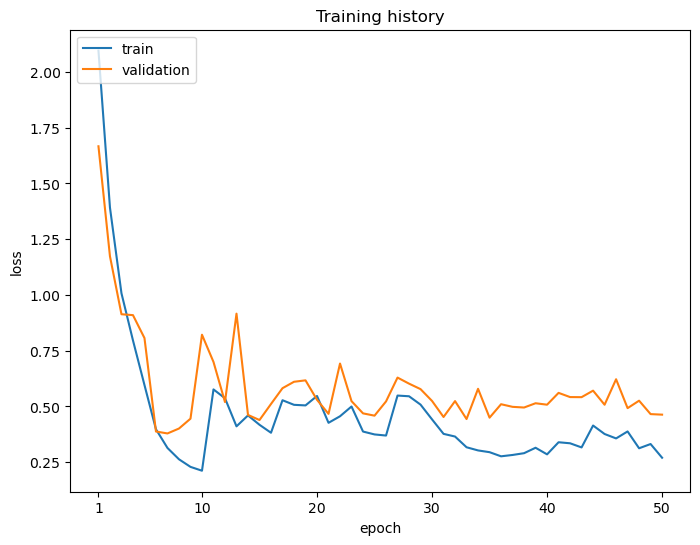

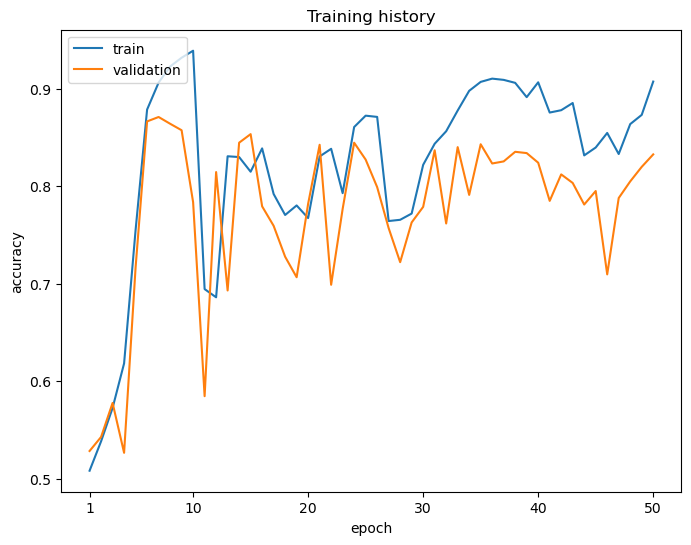

In [16]:
plot_history(history)

## Evaluate on Test Data

In [18]:
model = tf.keras.models.load_model(os.path.join(base_dir, "Models/IMDB_model3/IMDB_model3_07-0.8712.keras"))

In [19]:
pred = model.predict(test_data)

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [20]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

2024-12-20 13:52:43.368298: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
evaluate_classification_result(test_y, pred, classes=test_data_raw.class_names)

Confusion matrix (rows -> true, columns -> predicted):

       neg    pos
neg  10782   1718
pos   1876  10624


Class neg:
    Sensitivity (TPR):  86.256% (10782 of 12500)
    Specificity (TNR):  84.992% (10624 of 12500)
    Precision:          85.179% (10782 of 12658)
    Neg. pred. value:   86.080% (10624 of 12342)
Class pos:
    Sensitivity (TPR):  84.992% (10624 of 12500)
    Specificity (TNR):  86.256% (10782 of 12500)
    Precision:          86.080% (10624 of 12342)
    Neg. pred. value:   85.179% (10782 of 12658)

Overall accuracy:   85.624% (21406 of 25000)
Balanced accuracy:  85.624%


## Evaluate on Custom Test Data

In [22]:
my_text = ['this is probably the worst movie i have seen in my entire life it really sucks in the most obnoxious way',
           'if i had a dollar for each error in this movie i would be rich',
           'great movie wow i really really liked it',
           'complete trash show wasted money if you ask me',
           'this was one of the worst movies i have ever seen',
           'great movie would highly recommend',
           'it was an incredible experience and i would watch it again without second thought',
           'film bad',
           'it was more or less good']

In [23]:
my_test_data =  np.array([vectorize_layer(text) for text in my_text])
my_test_data

array([[  10,    7,  235, ...,    0,    0,    0],
       [  44,   11,   66, ...,    0,    0,    0],
       [  84,   17, 1340, ...,    0,    0,    0],
       ...,
       [   9,   13,   33, ...,    0,    0,    0],
       [  19,   81,    0, ...,    0,    0,    0],
       [   9,   13,   50, ...,    0,    0,    0]])

In [24]:
pred = model.predict(my_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [25]:
pd.DataFrame({'review': my_text, 'pred': pred.reshape(-1)})

,review,pred
0,this is probably the worst movie i have seen i...,0.021542
1,if i had a dollar for each error in this movie...,0.320421
2,great movie wow i really really liked it,0.976432
3,complete trash show wasted money if you ask me,0.020933
4,this was one of the worst movies i have ever seen,0.021185
5,great movie would highly recommend,0.983978
6,it was an incredible experience and i would wa...,0.980820
7,film bad,0.024695
8,it was more or less good,0.311267


In [26]:
!jupyter nbconvert --to html Ex5_Grimm_model2.ipynb

[NbConvertApp] Converting notebook Ex5_Grimm_model2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 481738 bytes to Ex5_Grimm_model2.html
